# Challenge
Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
#import fastai library to use ULMfit
from fastai.text import *
from pathlib import Path

## Loading the data

In [3]:
path = Path('../input/twitter-airline-sentiment/')
filename = 'Tweets.csv'

file_path = path / filename

# Read csv to pandas dataframe
tweet = pd.read_csv(file_path)
tweet.size

219600

In [4]:
tweet.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1378,569749422482960384,negative,0.6724,Flight Booking Problems,0.3673,United,NaN,PopsCutrona,NaN,0,@united Tried filling out the status match for...,NaN,2015-02-22 22:43:42 -0800,"San Francisco, Ca",Pacific Time (US & Canada)
8815,567825891209912320,positive,1.0000,NaN,NaN,Delta,NaN,carleycalla,NaN,0,@JetBlue tried again. Lovely customer service....,NaN,2015-02-17 15:20:16 -0800,"Boston, Massachusetts",Mountain Time (US & Canada)
705,570164810144481280,neutral,0.6762,NaN,NaN,United,NaN,8629Fissile,NaN,0,@united Okay thank you,NaN,2015-02-24 02:14:18 -0800,NaN,London
3373,568486216464785408,neutral,1.0000,NaN,NaN,United,NaN,Spofforth58,NaN,0,@united Hi if a premium ec upgrade was paid fo...,NaN,2015-02-19 11:04:10 -0800,NaN,NaN
5116,569334621252526080,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,_JASSSYY,NaN,0,@SouthwestAir your phone lines suck. I have a ...,NaN,2015-02-21 19:15:26 -0800,Beysus,Pacific Time (US & Canada)
5634,568848068977799168,neutral,0.6925,NaN,NaN,Southwest,NaN,TravelLeaders_,NaN,0,@SouthwestAir now accepting #Apple's Passbook ...,NaN,2015-02-20 11:02:02 -0800,"Liverpool, NY",Eastern Time (US & Canada)
12455,570180010125864960,neutral,1.0000,NaN,NaN,American,NaN,CamaroGuySteve,NaN,0,@AmericanAir Embassy Suites\n13341 Woodland Pa...,NaN,2015-02-24 03:14:42 -0800,NaN,NaN
1418,569724705063596032,negative,1.0000,Late Flight,1.0000,United,NaN,deltabrav0,NaN,0,@united does asap mean two hours worth of dela...,"[36.08161548, -115.14959772]",2015-02-22 21:05:29 -0800,"ÜT: 31.333857,-94.724549",Central Time (US & Canada)
10784,568877748967444480,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,TimAtConservis,NaN,0,@USAirways I keep calling your help line (800)...,NaN,2015-02-20 12:59:59 -0800,"Asheville, NC",NaN
736,570108801711341568,negative,1.0000,Customer Service Issue,0.6833,United,NaN,fairplay500,NaN,0,@united Outbound 2 bags 70 lbs bags Returning ...,"[0.0, 0.0]",2015-02-23 22:31:45 -0800,Huntsville AL USA,Central Time (US & Canada)


There are many columns but for sentiment analysis we only  need **airline_sentiment** and **text** columns

In [5]:

df = tweet[['airline_sentiment', 'text']]
df.sample(5)

,airline_sentiment,text
8163,neutral,@JetBlue yup! He said there would be flight ch...
4312,positive,"@united New Apple crâpe, amazing! Live from UA..."
11316,negative,"@USAirways Your software is broken. ""Call Cust..."
3849,negative,@united JH: going to process my refund for wif...
8813,negative,@JetBlue insane the craziness I've seen with J...


## Data analysis and preprocessing

Check for missing values

In [6]:
df.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

There are no missng values

Now let's check number of tweets in each class

In [7]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

There are a lot more negitive classes than other two classes.

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


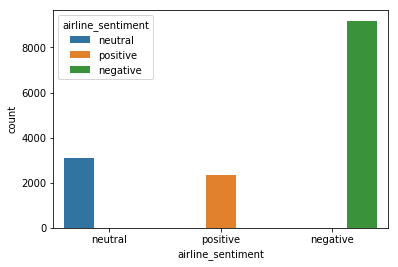

In [8]:
sns.countplot(x=df['airline_sentiment'],hue=df['airline_sentiment'])
print(df['airline_sentiment'].value_counts(normalize=True))

Around 62% tweets are negitive, 21% neutral and 16% positive.

Let's see the top words appearing in positive,negitive and neutral sentiments

In [9]:
#For positive class
from collections import Counter
top_n = 10
Counter(" ".join(df[df['airline_sentiment']=='positive'].text).split()).most_common(top_n)

[('the', 924),
 ('to', 923),
 ('for', 658),
 ('I', 574),
 ('@SouthwestAir', 548),
 ('you', 509),
 ('@JetBlue', 503),
 ('a', 501),
 ('@united', 472),
 ('and', 416)]

In [10]:
#For negitive class
Counter(" ".join(df[df['airline_sentiment']=='negative'].text).split()).most_common(top_n)

[('to', 5966),
 ('the', 3929),
 ('I', 3375),
 ('a', 3087),
 ('and', 2685),
 ('for', 2665),
 ('on', 2593),
 ('@united', 2510),
 ('my', 2225),
 ('@USAirways', 2207)]

In [11]:
#For neutral class
Counter(" ".join(df[df['airline_sentiment']=='neutral'].text).split()).most_common(top_n)

[('to', 1646),
 ('I', 1105),
 ('the', 928),
 ('a', 771),
 ('@united', 657),
 ('@SouthwestAir', 639),
 ('you', 631),
 ('on', 631),
 ('for', 598),
 ('@JetBlue', 578)]

As we can see particular airlinee company comes quite a lot in top words, this may be because in tweets we tag to reply to someone.

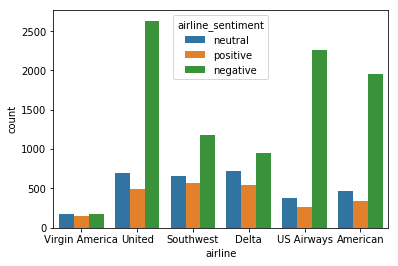

In [12]:
sns.countplot(x='airline', hue='airline_sentiment', data=tweet)

Negative sentiments are quite a lot for united airline, so if **united** is present then model may learn to associate it with negitive class, besides that in tops words of all classes contain some name of airline so we can remove those tag words.

##### Removing airline tags

In [13]:
airlines = tweet['airline'].unique()
airlines

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [14]:
import re
pattern = r'@[\w]+'
func = lambda x:re.sub(pattern, '', x)
df['text'] = df['text'].apply(func)
df.sample(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,airline_sentiment,text
11408,negative,: I experienced what defines customer service ...
12472,negative,needs to get their shit together. 2 counter p...
2486,negative,I'm strongly considering taking my business e...
13628,negative,You apologise for HIS frustrations &amp; HIS...
9976,negative,is absolute crap this week!!


## Model Building

In [15]:
#path = Path.resolve('../input').resolve()
#train_valid, test = train_test_split(df, test_size=0.25)
train, valid = train_test_split(df, test_size=0.25)
data_lm = TextLMDataBunch.from_df('./', train, valid)

moms = (0.8,0.7)
wd = 0.1

In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.2)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 5.25E-02


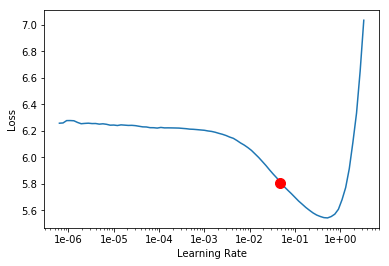

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(1, 4.79E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.421053,3.981534,0.266317,00:06


In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, 4.75E-02, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.031477,4.105789,0.254096,00:07
1,4.110241,4.089138,0.257623,00:07
2,4.005008,3.980950,0.270257,00:07
3,3.692346,3.852183,0.287489,00:07
4,3.134244,3.899277,0.290625,00:07


In [29]:
learn.predict('It was a decent experience', n_words=10
             )

'It was a decent experience and was given a bit of location work .'

In [30]:
learn.predict('Service was not that great', n_words=10)

'Service was not that great ! Kudos to your incompetence at SNA !'

In [31]:
learn.save_encoder('encoder.pth')

### Building the classifer

In [33]:
classifier = TextClasDataBunch.from_df('./', train, valid, vocab=data_lm.train_ds.vocab,
                                          label_cols='airline_sentiment', text_cols='text')
classifier.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
xxbos xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
"xxbos i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.09E-02


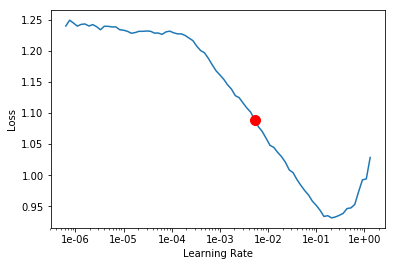

In [34]:
learn = text_classifier_learner(classifier, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('encoder.pth')
learn.freeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(1, 5.25E-03, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.613960,0.517981,0.795628,00:05


In [36]:
learn.freeze_to(-2)
lr = 3.63E-03 / 5
learn.fit_one_cycle(1, slice(lr/2**4, lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.551680,0.513375,0.802459,00:05


In [37]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.533685,0.499139,0.800273,00:07


In [38]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(10, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.511049,0.499478,0.802732,00:10
1,0.488355,0.504094,0.807104,00:09
2,0.503683,0.495299,0.808470,00:10
3,0.489206,0.496307,0.809290,00:09
4,0.494796,0.492564,0.808197,00:09
5,0.489044,0.491752,0.809290,00:09
6,0.494977,0.490016,0.807104,00:09
7,0.478911,0.491515,0.812022,00:09
8,0.479678,0.491514,0.809836,00:09
9,0.462030,0.503650,0.804918,00:09


In [39]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.448726,0.506953,0.806284,00:09
1,0.455157,0.497115,0.809016,00:09
2,0.474537,0.491693,0.807923,00:09
3,0.477697,0.490143,0.810382,00:09
4,0.449905,0.489754,0.810656,00:10


In [40]:
learn.predict('Great flight')

(Category positive, tensor(2), tensor([0.0352, 0.0749, 0.8898]))

In [41]:
learn.predict('staff behaviour was not good')

(Category negative, tensor(0), tensor([0.9269, 0.0118, 0.0613]))

In [42]:
learn.predict('service was good but flight got delayed')

(Category negative, tensor(0), tensor([0.9744, 0.0111, 0.0145]))

In [48]:
str(learn.predict('ok')[0]) == 'neutral'

True

### Accuracy

In [49]:
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.811


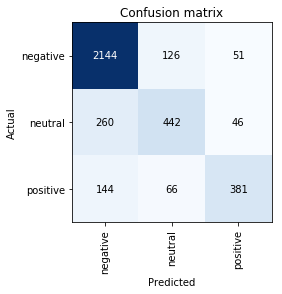

In [50]:
interp.plot_confusion_matrix()

In [51]:
learn.save('model.pth')

### Test Accuracy

Accuracy on unseen data

In [57]:
valid.shape[0]

3660

In [70]:
k = 0
for i in valid.iterrows():
    k = k+1
    if k==3:
        break
    else:
        print(i)
        
print('\n')
print(i[1]['text'])

(5791, airline_sentiment                                             negative
text                  it'd be nice if I could get an answer, even a...
Name: 5791, dtype: object)
(3720, airline_sentiment                                             negative
text                  nope. Really. No window at all for 10A. 10F h...
Name: 3720, dtype: object)


 with a glass of wine once we hit altitude?


In [76]:
from tqdm import tqdm_notebook as tqdm

In [77]:
pre = []
for sentiment in tqdm(valid.iterrows()):
    p = str(learn.predict(sentiment[1]['text'])[0])
    pre.append(p)

pre

['negative',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'negative',
 'negative',
 'negative',
 'negative',
 'positive',
 'negative',
 'negative',
 'negative',
 'neutral',
 'neutral',


In [78]:
pred = pd.DataFrame(pre)
pred.sample(5)

,0
36,negative
2627,negative
457,positive
2995,negative
2720,negative


In [87]:
valid = valid.reset_index()
valid.sample(5)

,index,airline_sentiment,text
592,8617,negative,you wanna help out? How about you reimburse t...
608,8237,positive,thanks so much!! ❤️✨ very relaxing flight!
424,5441,negative,I lost my luggage. My birthday wish is to fin...
3141,688,negative,Why do I have to pay $ 17 for wifi with an in...
1028,12621,positive,Thank you


In [88]:
pred = (pre[0] == valid['airline_sentiment'])

<bound method Series.unique of 0        True
1        True
2       False
3       False
4       False
        ...  
3655     True
3656     True
3657     True
3658     True
3659     True
Name: airline_sentiment, Length: 3660, dtype: bool>

In [98]:
accuracy = sum(pred)/len(pred)
print('Accuracy on unseen data is {}'.format(accuracy))

Accuracy on unseen data is 0.6341530054644808
